In [1]:
import os

os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.97'

import jax
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt

import fwd_model_tools as ffi

/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
key = jax.random.PRNGKey(0)
resolution = 128
mesh_size = (resolution,) * 3
box_size = (1000.0, 1000.0, 1000.0)
nside = resolution
flatsky_npix = (resolution, resolution)
field_size = (10, 10)
nb_shells = 4
cosmo = ffi.Planck18()
ts = jnp.array([0.2 , 0.4, 1.0])

initial_field = ffi.gaussian_initial_conditions(
    key, mesh_size, box_size,
    cosmo=cosmo,
    nside=nside,
    flatsky_npix=flatsky_npix,
    field_size=field_size,
    observer_position=(0.0, 0.0, 0.0),
)

# LPT at early time to initialize PM
t0 = 0.1
dx, p = ffi.lpt(cosmo, initial_field, scale_factor_spec=t0, order=1, painting=ffi.PaintingOptions(target="particles"))
print(f"LPT initialized at a={t0}")
print(f"Displacement status: {dx.status}")

LPT initialized at a=0.1
Displacement status: FieldStatus.LPT1


In [3]:
furthest_requested_scale_factor = jnp.min(ts)
furthest_scale_factor = jc.background.a_of_chi(cosmo, initial_field.max_comoving_radius).squeeze()
needed_comoving_distance = jc.background.radial_comoving_distance(cosmo, furthest_requested_scale_factor).squeeze() 

print(f"Furthest scale factor of the shells: {furthest_requested_scale_factor:.3f}") 
print(f"Furthest scale factor of the box: {furthest_scale_factor:.3f}") 
print(f"Number of replications needed: {jnp.ceil(needed_comoving_distance / box_size[0]):.1f}")

Furthest scale factor of the shells: 0.200
Furthest scale factor of the box: 0.732
Number of replications needed: 5.0


Se we need to make 5 replications of the box and to do that you can use the `TelephotoInterp` interpolation kernel which will automatically replicate the box as needed to make sure that the painting is correct. You can also use the `nb_shells` argument to make sure that the snapshots are equally spaced in comoving distance and that the furthest one is inside the box.

The maximum amounts of shells is 47 because of the symmetries of the cube. and this only supports flat sky painting. 

In [4]:
solver_kkd = ffi.ReversibleDoubleKickDrift(
    interp_kernel=ffi.TelephotoInterp(painting=ffi.PaintingOptions(target="flat", drift_on_lightcone=False)),
)
solver_no_replicate = ffi.ReversibleDoubleKickDrift(
    interp_kernel=ffi.NoInterp(painting=ffi.PaintingOptions(target="flat", drift_on_lightcone=False)),
)


result_kkd = ffi.nbody(
    cosmo, dx, p,
    t1=1.0, dt0=0.05,
    ts=ts,
    solver=solver_kkd,
).block_until_ready()

print(f"=="*20)

result_no_replicate = ffi.nbody(cosmo, dx, p, t1=1.0, dt0=0.05, ts=ts, solver=solver_no_replicate, )


self.array sharding: GSPMDSharding({replicated}, memory_kind=device)
self.array sharding after cast: GSPMDSharding({replicated}, memory_kind=device)
data sharding before map: GSPMDSharding({replicated}, memory_kind=device)
positions sharding: GSPMDSharding({replicated}, memory_kind=device)
xy sharding: GSPMDSharding({replicated}, memory_kind=device)
dz sharding: GSPMDSharding({replicated}, memory_kind=device)
self.array sharding: GSPMDSharding({replicated}, memory_kind=device)
self.array sharding after cast: GSPMDSharding({replicated}, memory_kind=device)
data sharding before map: GSPMDSharding({replicated}, memory_kind=device)
positions sharding: GSPMDSharding({replicated}, memory_kind=device)
xy sharding: GSPMDSharding({replicated}, memory_kind=device)
dz sharding: GSPMDSharding({replicated}, memory_kind=device)
Advancing from shell index -1 at time 0.2
is it snapshot time? True
Painting shell at comoving center 4968.985516259013 Mpc/h with width 1936.1701874034352 Mpc/h and shell in

/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax/_src/debugging.py:201: UserWarning: 
                NoInterp does not support tiling.
                Your furthest shell is at 5937.07 Mpc/h,
                but your box only extends to 1000.00 Mpc/h.
                Your simulations will run but will have artifacts for the far shells.
            
  debug_callback_p.impl(


Painting shell at comoving center 4968.985516259013 Mpc/h with width 1936.1701874034352 Mpc/h and shell index is 0
Painting shell at comoving center 3032.8153288555773 Mpc/h with width 1936.170187403436 Mpc/h and shell index is 1
Painting shell at comoving center 0.0 Mpc/h with width 4129.460470307718 Mpc/h and shell index is 2


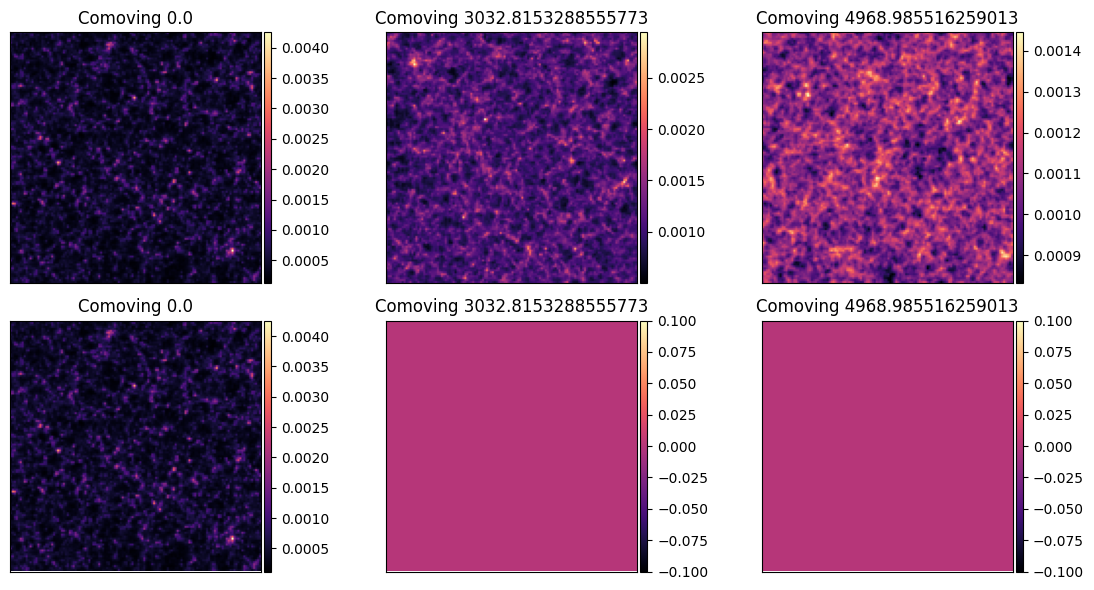

In [5]:
fig , axes = plt.subplots(2,3, figsize=(12,6))
result_kkd.apply_fn(jnp.log1p).plot(ax=axes[0], show_ticks=False , titles=[f"Comoving {i}" for i in result_kkd.comoving_centers])
result_no_replicate.apply_fn(jnp.log1p).plot(ax=axes[1], show_ticks=False , titles=[f"Comoving {i}" for i in result_no_replicate.comoving_centers])

plt.tight_layout()
plt.show()

So you can see that the density that does not intersect the box is zeros (nothing is painted) but with the `TelephotoInterp` interpolation kernel the density is correctly painted

# Spherical painting

for spherical painting `TelephotoInterp` does not work since it only replicates the box in the plane of the sky but not along the line of sight. In this case you can use the `OnionTiler` which will replicate the box along the line of sight as well.

The amount of replication follows this simple formula: $(2 \times \text{nb\_shells} + 1)^3$ so for 1 shell ouside the box you need to replicate the box 27 times.

`OnionTiler` only supports a single replication step (as in 27 boxes) so you need to make sure that the furthest shell is within the replicated box.



In [6]:

initial_field = ffi.gaussian_initial_conditions(
    jax.random.key(1), mesh_size, box_size,
    cosmo=cosmo,
    nside=nside,
    flatsky_npix=flatsky_npix,
    field_size=field_size,
    observer_position=(0.5, 0.5, 0.5),
)

# LPT at early time to initialize PM
t0 = 0.1
dx, p = ffi.lpt(cosmo, initial_field, scale_factor_spec=t0, order=1, painting=ffi.PaintingOptions(target="particles"))


max_radius = initial_field.max_comoving_radius
max_possible_radius = max_radius * 2
max_a = jc.background.a_of_chi(cosmo, max_possible_radius).squeeze()
ts = jnp.linspace(max_a, 1.0, 3)


solver_kkd = ffi.ReversibleDoubleKickDrift(
    interp_kernel=ffi.TelephotoInterp(painting=ffi.PaintingOptions(target="spherical", drift_on_lightcone=True)),
)
solver_onion = ffi.ReversibleDoubleKickDrift(
    interp_kernel=ffi.OnionTiler(painting=ffi.PaintingOptions(target="spherical", drift_on_lightcone=True)),
)
solver_no_replicate = ffi.ReversibleDoubleKickDrift(
    interp_kernel=ffi.NoInterp(painting=ffi.PaintingOptions(target="spherical", drift_on_lightcone=True)),
)

result_kkd = ffi.nbody(
    cosmo, dx, p,
    t1=1.0, dt0=0.05,
    ts=ts,
    solver=solver_kkd,
)

result_no_replicate = ffi.nbody( cosmo, dx, p, t1=1.0, dt0=0.05, ts=ts, solver=solver_no_replicate)

result_onion = ffi.nbody( cosmo, dx, p, t1=1.0, dt0=0.05, ts=ts, solver=solver_onion)


/home/wassim/Projects/NBody/fwd_model_tools/src/fwd_model_tools/pm/interp.py:511: UserWarning: 
            TelephotoInterp is designed for narrow FOV flat-sky projections.
            Using it for spherical painting will cause significant artifacts.
            use for illustriative purposes only.
            
  warnings.warn("""


Advancing from shell index -1 at time 0.2
is it snapshot time? False
Advancing from shell index -1 at time 0.25
is it snapshot time? False
Advancing from shell index -1 at time 0.3
is it snapshot time? False
Advancing from shell index -1 at time 0.35
is it snapshot time? False
Advancing from shell index -1 at time 0.39999999999999997
is it snapshot time? False
Advancing from shell index -1 at time 0.44999999999999996
is it snapshot time? False
Advancing from shell index -1 at time 0.49999999999999994
is it snapshot time? False
Advancing from shell index -1 at time 0.5499999999999999
is it snapshot time? False
Advancing from shell index -1 at time 0.6
is it snapshot time? False
Advancing from shell index -1 at time 0.65
is it snapshot time? False
Advancing from shell index -1 at time 0.7000000000000001
is it snapshot time? False
Advancing from shell index -1 at time 0.7321755967192742
is it snapshot time? True
Painting shell at comoving center 999.9999999999989 Mpc/h with width 553.1866

/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax/_src/debugging.py:201: UserWarning: 
                NoInterp does not support tiling.
                Your furthest shell is at 1276.59 Mpc/h,
                but your box only extends to 500.00 Mpc/h.
                Your simulations will run but will have artifacts for the far shells.
            
  debug_callback_p.impl(


Painting shell at comoving center 999.9999999999989 Mpc/h with width 553.1866997085958 Mpc/h and shell index is 0
Painting shell at comoving center 446.8133002914031 Mpc/h with width 553.1866997085957 Mpc/h and shell index is 1
Painting shell at comoving center 0.0 Mpc/h with width 340.4399008742105 Mpc/h and shell index is 2
Drifting particles to lightcone crossing time for single-tile painting.
Drifting particles to lightcone crossing time for single-tile painting.


/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/healpy/visufunc.py:1630: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  ax.graticule(dpar=dpar, dmer=dmer, coord=coord, local=local, **kwds)
/tmp/ipykernel_172019/2740041227.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


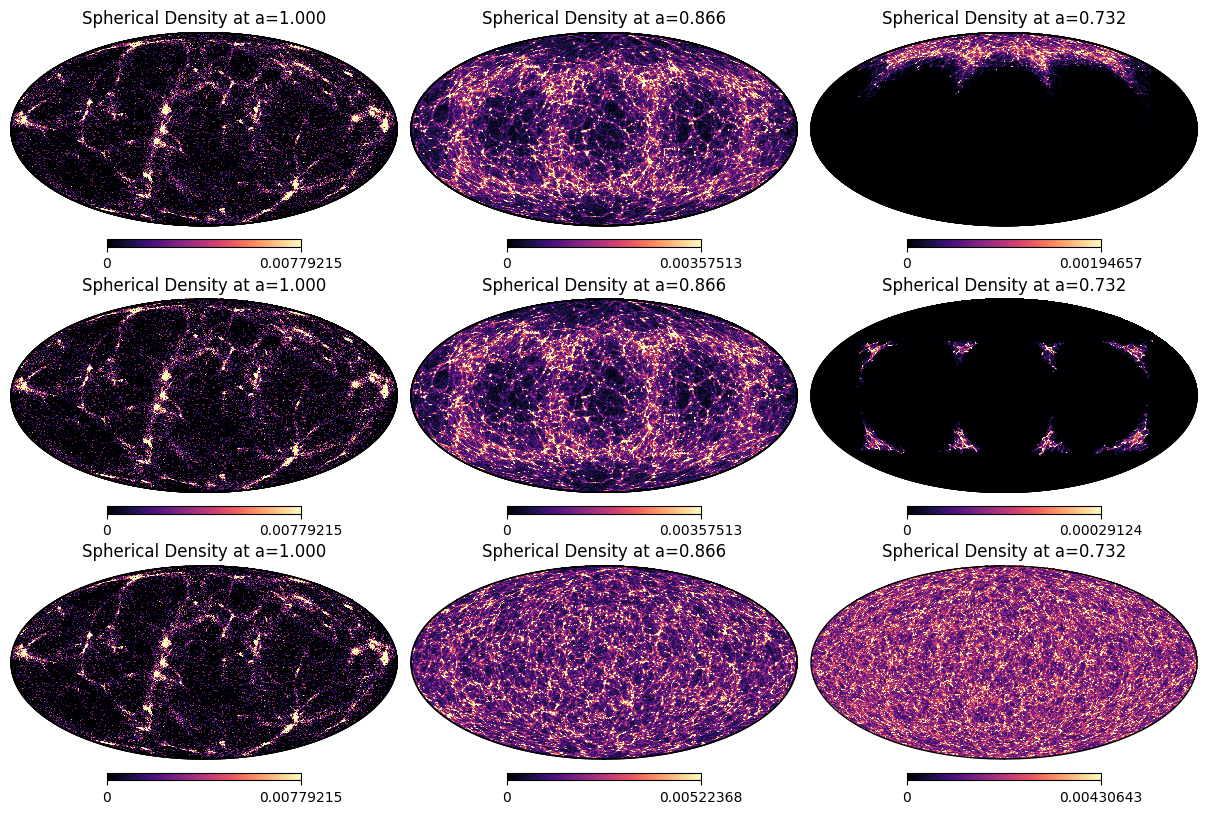

In [7]:
fig , axes = plt.subplots(3,3, figsize=(12,8))
result_kkd.apply_fn(jnp.log1p).plot(ax=axes[0], show_ticks=False)
result_no_replicate.apply_fn(jnp.log1p).plot(ax=axes[1], show_ticks=False)
result_onion.apply_fn(jnp.log1p).plot(ax=axes[2], show_ticks=False)

plt.tight_layout()
plt.show()

The telephoto interpolation only fills the of the sphere which is what the observer has infront of him

While you can see that using no interp this causes the furthest shell to be usually empty or have circular artifacts because the far particles intersecging only with the corner of the box these artifacts are apparent even on particle fields that are mostly inside

Using the `OnionTiler` interpolation kernel, the painting is correct and there are no artifacts even for the furthest shell.

